# Aerobicity phenotype: data analysis, processing, and visualization

In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_aerob_data, pca_run_and_plot, tsne_plot, plot_accuracy_metric

TAX_LEVEL = "phylum"
DATA_DIRECTORY = "data_aerob"
RANDOM_SEED = 42
OUTPUT_DIRECTORY = f"../{DATA_DIRECTORY}/plots_{TAX_LEVEL}_tax_level"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = f"../{DATA_DIRECTORY}/input_data/train_taxa_names_{TAX_LEVEL}_tax_level"
X_val_train, y_label_train, X_column_names, taxa_group_names_train = read_aerob_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = f"../{DATA_DIRECTORY}/input_data/test_taxa_names_{TAX_LEVEL}_tax_level"
X_val_test, y_label_test, X_column_names, taxa_group_names_test = read_aerob_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

In [2]:
aerob_train = float(sum(y_label_train.cpu()))
anaerob_train = float(len(y_label_train.cpu()) - aerob_train)
print(f"Number of Aerobs in train = {aerob_train}, which is {round(100*aerob_train/(aerob_train+anaerob_train),2)} %")
print(f"Number of Anaerobs = {anaerob_train}, which is {round(100*anaerob_train/(aerob_train+anaerob_train),2)} %\n")

aerob_test = float(sum(y_label_test.cpu()))
anaerob_test = float(len(y_label_test.cpu()) - aerob_test)
print(f"Number of Aerobs in test = {aerob_test}, which is {round(100*aerob_test/(aerob_test+anaerob_test),2)} %")
print(f"Number of Anaerobs = {anaerob_test}, which is {round(100*anaerob_test/(aerob_test+anaerob_test),2)} %")

Number of Aerobs in train = 1401.0, which is 61.15 %
Number of Anaerobs = 890.0, which is 38.85 %

Number of Aerobs in test = 705.0, which is 81.03 %
Number of Anaerobs = 165.0, which is 18.97 %


#### 2. PCA and tSNE projections

In [3]:
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

Data after PCA reduction: (2291, 20)
Explained variance ratio: [0.14222705 0.07006041 0.0631517  0.03842594 0.03094155 0.02524055
 0.02281191 0.0185853  0.01382748 0.0120532  0.01009886 0.00953793
 0.00842523 0.00822675 0.00779109 0.00736461 0.00687967 0.00592675
 0.00555244 0.00505414]
Total explained variance: 0.5121825644697465
Shape of the projected data = (2291, 2)


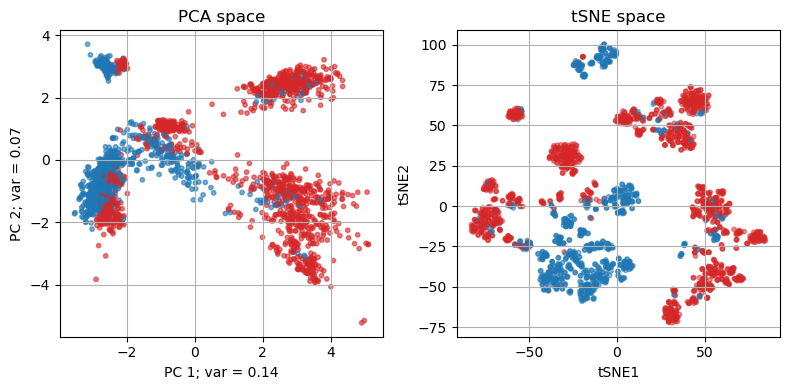

In [4]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:blue", "tab:red"])
category_names = ["anaerobe" if yi == 0 else "aerobe" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, y_label_train.cpu(), colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phenot.pdf", format="pdf")
plt.show()

Data after PCA reduction: (2291, 20)
Explained variance ratio: [0.14222705 0.07006041 0.0631517  0.03842594 0.03094155 0.02524055
 0.02281191 0.0185853  0.01382748 0.0120532  0.01009886 0.00953793
 0.00842523 0.00822675 0.00779109 0.00736461 0.00687969 0.0059271
 0.0055522  0.00505198]
Total explained variance: 0.5121805284883015
Shape of the projected data = (2291, 2)


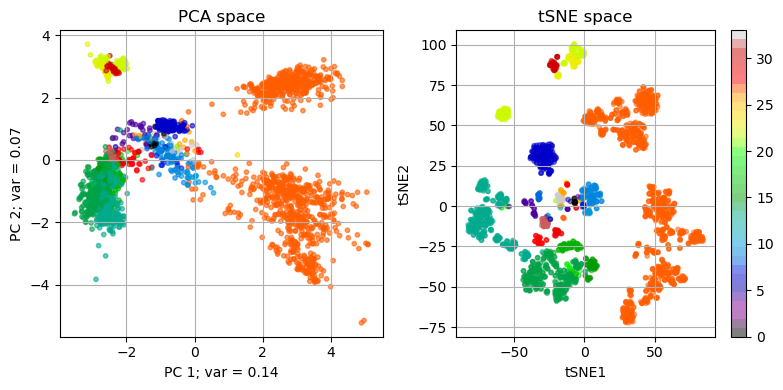

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

plt.figure(figsize=(8, 4))

# Put to True, if a legend is needed (it might be too longr for some taxonomy levels)
legend = False

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:blue", "tab:red"])
category_names = ["anaerobe" if yi == 0 else "aerobe" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, label_encoder.fit_transform(taxa_group_names_train), taxa_group_names_train, None, legend);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, label_encoder.fit_transform(taxa_group_names_train), None);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_orig_phylogen.pdf", format="pdf")
plt.show()

#### 3. XGBoost training and feature selection

First, find baseline (for all GOGs) test and cross-validation accuracy measures.

In [6]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Suppress the UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [7]:
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_val_train, y_label_train, X_val_test, y_label_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

XGBoost baseline test accuracy (all features) = {'accuracy': 0.9862068965517241, 'precision': 0.9887165021156559, 'recall': 0.9943262411347518, 'f1': 0.9915134370579916, 'roc_auc': 0.9941027294218784}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9862068965517241, 'precision': 0.9887165021156559, 'recall': 0.9943262411347518, 'f1': 0.9915134370579916, 'roc_auc': 0.9941027294218784}


In [8]:
X_train_np = np.array(X_val_train.cpu())
X_train_transposed = X_train_np.T

In [9]:
from feature_selection.feature_selection_utils import random_feat_removal_curves

num_runs = 4
feat_step = 10

feat_removal = False
cv_accur_arr_all_runs_mn, cv_accur_arr_all_runs_std, test_accur_arr_all_runs_mn, test_accur_arr_all_runs_std, num_feat = random_feat_removal_curves(X_val_train, X_val_test, y_label_train, y_label_test, num_runs, feat_step, DEVICE, feat_removal);    

In [10]:
feat_removal = True
cv_accur_arr_all_runs_mn_rem, cv_accur_arr_all_runs_std_rem, test_accur_arr_all_runs_mn_rem, test_accur_arr_all_runs_std_rem, num_feat = random_feat_removal_curves(X_val_train, X_val_test, y_label_train, y_label_test, num_runs, feat_step, DEVICE, feat_removal);

#### 3.1 Feature selection with Mutual Information

In [11]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, RANDOM_SEED)

In [12]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0108', 'COG1587', 'COG0274', 'COG0025', 'COG1610', 'COG0064', 'COG0506', 'COG1053', 'COG0270', 'COG0317']


Data after PCA reduction: (2291, 5)
Explained variance ratio: [0.56958586 0.13140738 0.07043785 0.05918599 0.04582534]
Total explained variance: 0.876442413777113
Shape of the projected data = (2291, 2)


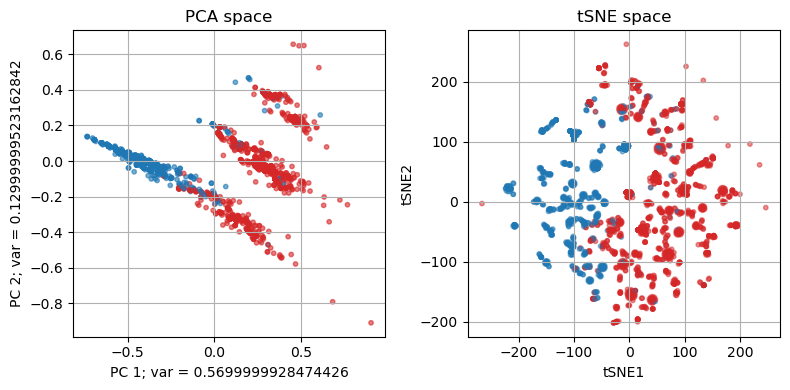

In [13]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_mi_feat.pdf", format="pdf")
plt.show()


In [14]:
feat_step = 10
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [15]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [16]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': 0.9183739094861622, 'precision': 0.913150625910285, 'recall': 0.9578723945094051, 'f1': 0.934872697106028, 'roc_auc': 0.9122121322038351}
{'accuracy': 0.9551724137931035, 'precision': 0.978448275862069, 'recall': 0.9659574468085106, 'f1': 0.9721627408993576, 'roc_auc': 0.9386202450032237}


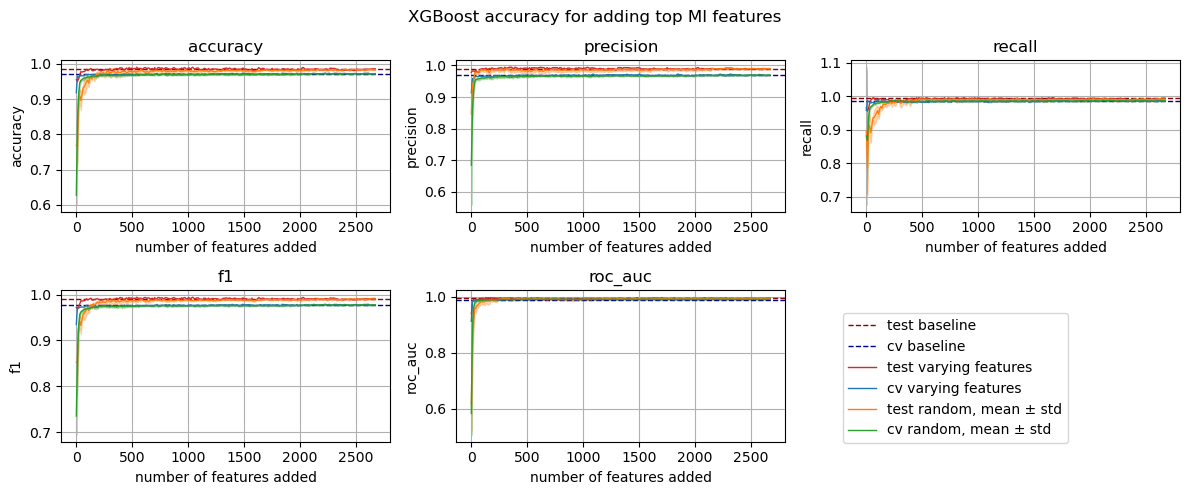

In [17]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top MI features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_add.pdf", format="pdf")   

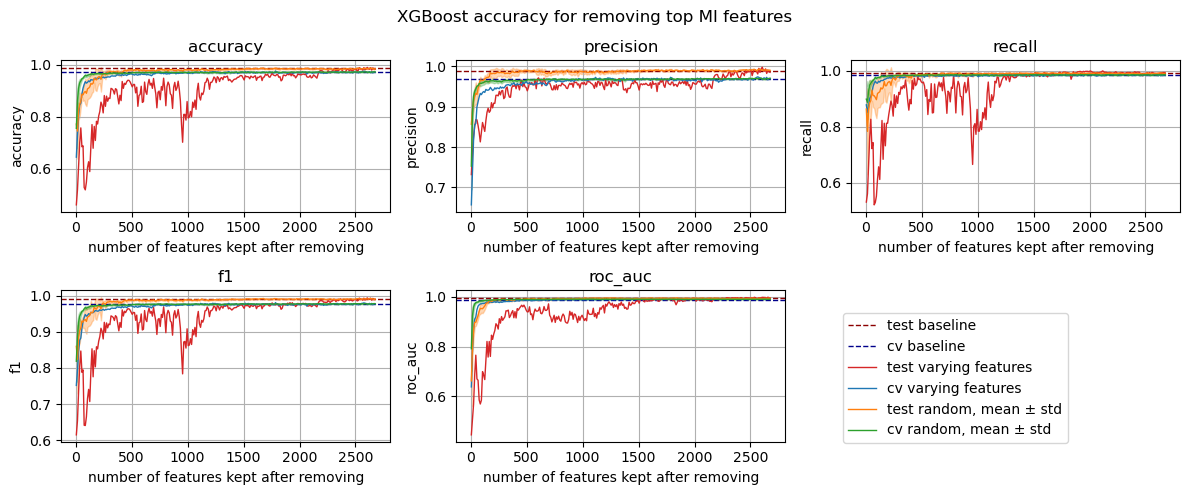

In [18]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top MI features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_remov.pdf", format="pdf")  

#### 3.2 Feature selection with Random Forest

In [19]:
from feature_selection.feature_selection_utils import random_forest_features
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, RANDOM_SEED)

Original feature count: 2676, Selected feature count: 281


In [20]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG1587', 'COG0317', 'COG1322', 'COG0364', 'COG1053', 'COG0274', 'COG1610', 'COG0108', 'COG0542', 'COG0842']


In [21]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (2291, 5)
Explained variance ratio: [0.5445725  0.10578191 0.08212718 0.06959529 0.0529348 ]
Total explained variance: 0.8550116457045078
Shape of the projected data = (2291, 2)


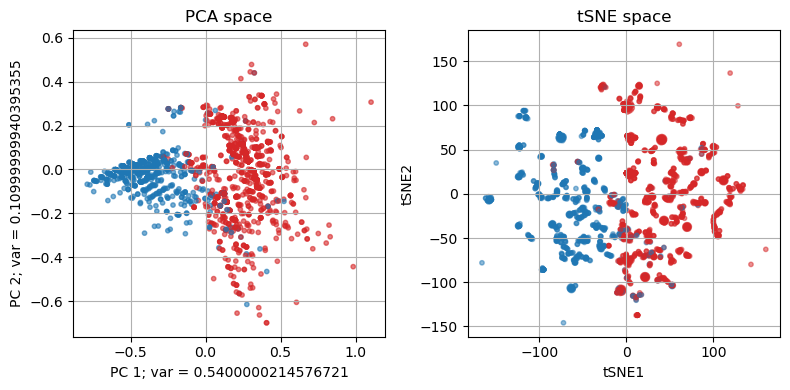

In [22]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_randfor_feat.pdf", format="pdf")
plt.show()

In [23]:
feat_step = 10
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [24]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': 0.8939397398940168, 'precision': 0.9138325295041886, 'recall': 0.912938485002542, 'f1': 0.9132198714801671, 'roc_auc': 0.9127787068084061}
{'accuracy': 0.9287356321839081, 'precision': 0.9374149659863945, 'recall': 0.9773049645390071, 'f1': 0.9569444444444445, 'roc_auc': 0.8535912314635719}


In [25]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

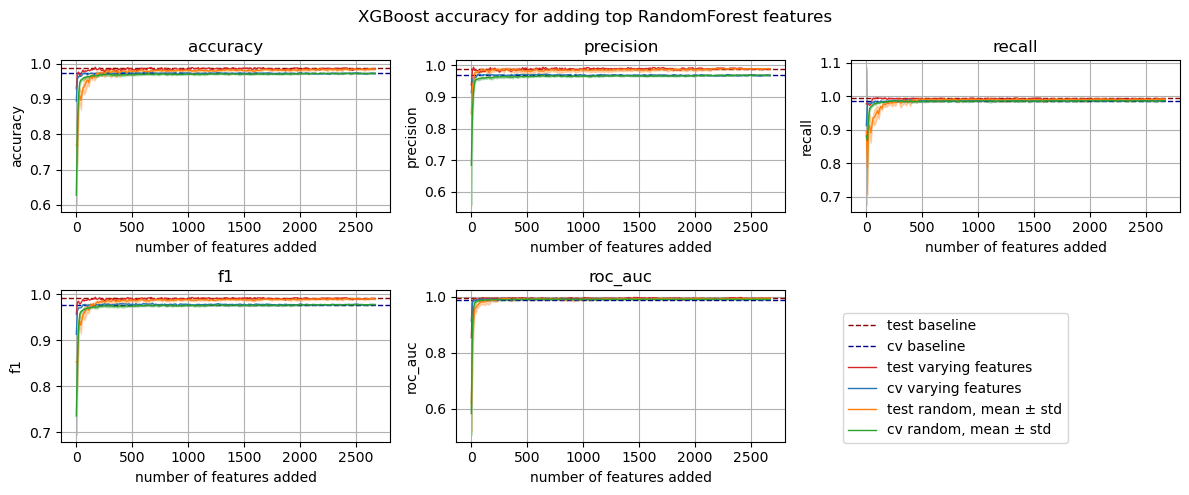

In [26]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top RandomForest features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_add.pdf", format="pdf") 

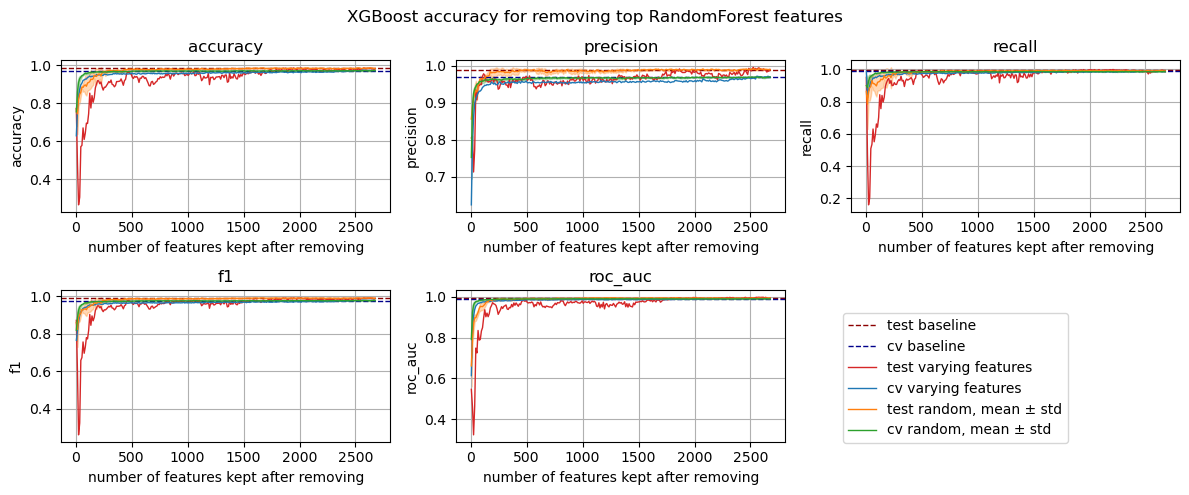

In [27]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top RandomForest features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_remov.pdf", format="pdf")  

#### 3.3 Feature selection with SHAP values

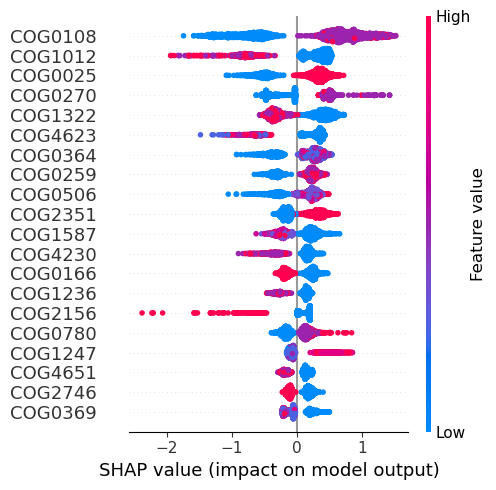

In [28]:
from feature_selection.feature_selection_utils import shap_features

device = 'cpu'
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, device) 

In [29]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG0108', 'COG1012', 'COG0025', 'COG0270', 'COG1322', 'COG4623', 'COG0364', 'COG0259', 'COG0506', 'COG2351']


Data after PCA reduction: (2291, 5)
Explained variance ratio: [0.53267026 0.14227132 0.07467574 0.06205244 0.05392685]
Total explained variance: 0.8655966110527515
Shape of the projected data = (2291, 2)


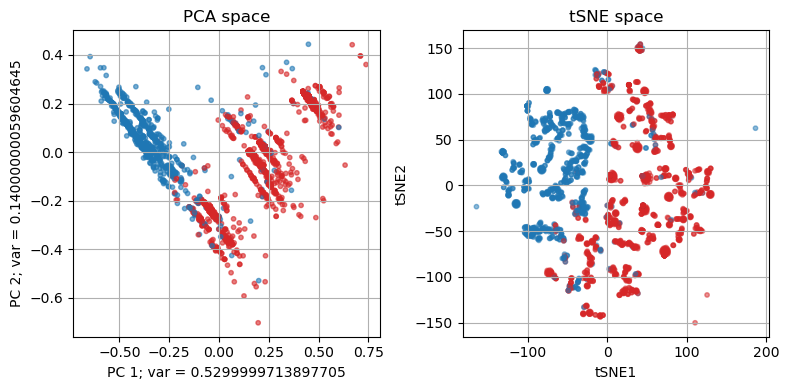

In [30]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, RANDOM_SEED, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_shap_feat.pdf", format="pdf")
plt.show()

In [31]:
feat_step = 10
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

In [32]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

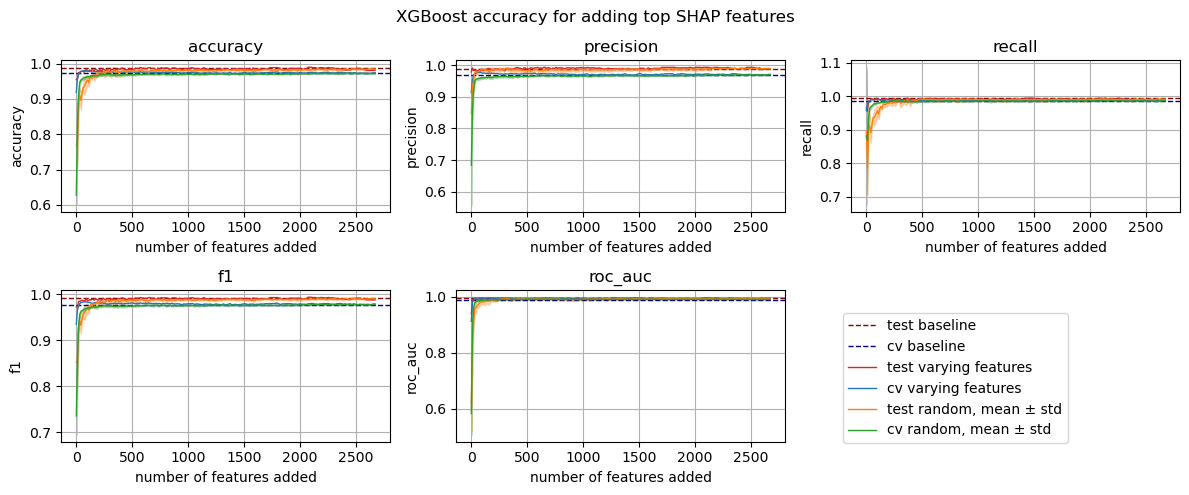

In [33]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr], [scores[metric] for scores in cv_accur_arr], [scores[metric] for scores in test_accur_arr_all_runs_mn], [scores[metric] for scores in test_accur_arr_all_runs_std], [scores[metric] for scores in cv_accur_arr_all_runs_mn], [scores[metric] for scores in cv_accur_arr_all_runs_std], num_feat)
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features added")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top SHAP features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_add.pdf", format="pdf") 

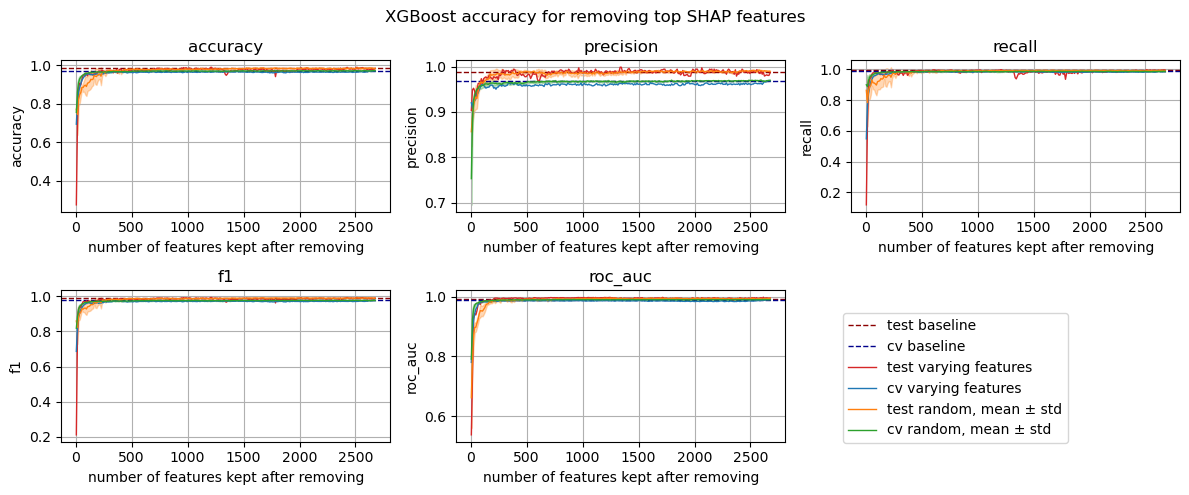

In [34]:
fig = plt.figure(figsize=(12, 5))
tot_num_feat = X_val_train.cpu().shape[1]

metrics = ['accuracy','precision','recall', 'f1','roc_auc']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plot_accuracy_metric(test_accuracy_scores[metric], cv_accuracy_scores[metric], [scores[metric] for scores in test_accur_arr_rem], [scores[metric] for scores in cv_accur_arr_rem], [scores[metric] for scores in test_accur_arr_all_runs_mn_rem], [scores[metric] for scores in test_accur_arr_all_runs_std_rem], [scores[metric] for scores in cv_accur_arr_all_runs_mn_rem], [scores[metric] for scores in cv_accur_arr_all_runs_std_rem], [tot_num_feat - n  for n in num_feat])
    plt.ylabel(metric)
    plt.title(metric)
    plt.xlabel("number of features kept after removing")
plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top SHAP features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_remov.pdf", format="pdf")  

#### 4. Feature comparison

In [35]:
import pandas as pd
from feature_selection.feature_selection_utils import make_cog_descr

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

df = pd.DataFrame(data)
make_cog_descr(df)

,MI,RandomForest,SHAP
0,"COG0108: 3,4-dihydroxy-2-butanone 4-phosphate ...",COG1587: Uroporphyrinogen-III synthase,"COG0108: 3,4-dihydroxy-2-butanone 4-phosphate ..."
1,COG1587: Uroporphyrinogen-III synthase,"COG0317: (p)ppGpp synthase/hydrolase, HD super...",COG1012: Acyl-CoA reductase or other NAD-depen...
2,COG0274: Deoxyribose-phosphate aldolase,COG1322: DNA anti-recombination protein (rearr...,COG0025: NhaP-type Na+/H+ or K+/H+ antiporter
3,COG0025: NhaP-type Na+/H+ or K+/H+ antiporter,COG0364: Glucose-6-phosphate 1-dehydrogenase,COG0270: DNA-cytosine methylase Dcm or eukaryo...
4,COG1610: Uncharacterized conserved protein Yqe...,COG1053: Succinate dehydrogenase/fumarate redu...,COG1322: DNA anti-recombination protein (rearr...
5,COG0064: Asp-tRNAAsn/Glu-tRNAGln amidotransfer...,COG0274: Deoxyribose-phosphate aldolase,COG4623: Membrane-bound lytic murein transglyc...
6,COG0506: Proline dehydrogenase,COG1610: Uncharacterized conserved protein Yqe...,COG0364: Glucose-6-phosphate 1-dehydrogenase
7,COG1053: Succinate dehydrogenase/fumarate redu...,"COG0108: 3,4-dihydroxy-2-butanone 4-phosphate ...",COG0259: Pyridoxine/pyridoxamine 5'-phosphate ...
8,COG0270: DNA-cytosine methylase Dcm or eukaryo...,"COG0542: ATP-dependent Clp protease, ATP-bindi...",COG0506: Proline dehydrogenase
9,"COG0317: (p)ppGpp synthase/hydrolase, HD super...","COG0842: ABC-type multidrug transport system, ...",COG2351: 5-hydroxyisourate hydrolase (purine c...


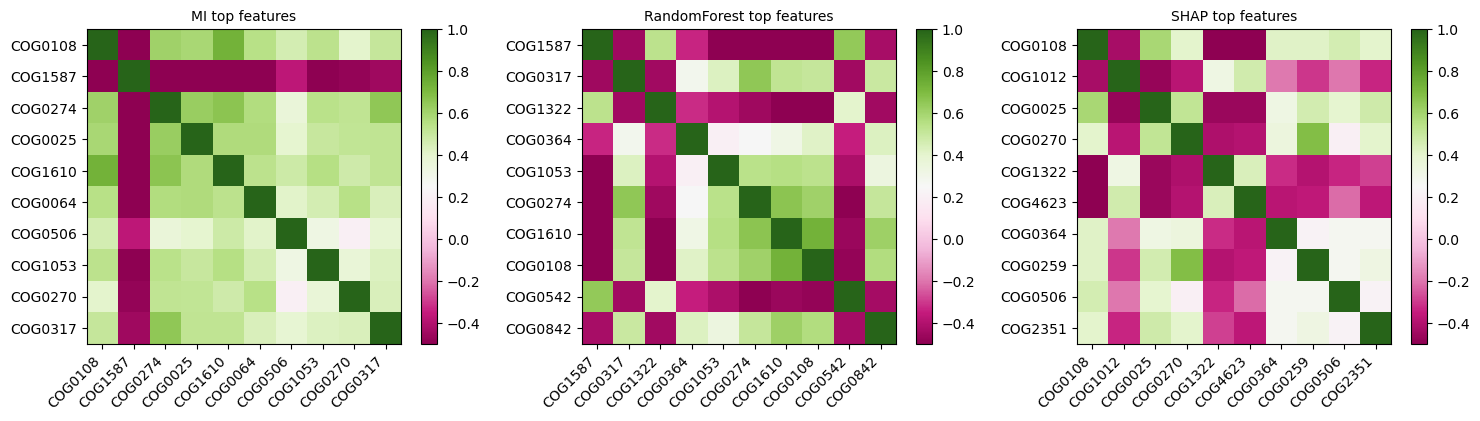

In [36]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/correlat_matr_top{N}_feat.pdf", format="pdf")
plt.show()


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os

import requests

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler

import torch

from feature_selection.feature_selection_utils import (
    mutual_info_features,
    random_forest_features,
    shap_features,
    xgboost_train_accur,
    xgboost_accur_select_features,
    plot_accuracy_metric,
    make_cog_descr
)

In [3]:
# Add the parent directory to sys.path (to import util function)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.utils import read_aerob_data, pca_run_and_plot, tsne_plot

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42

## 1. Read the dataset

In [5]:
#full data
X, y, full_data = read_aerob_data()

Read in 47894 GTDB representatives
Data without noise: 3161

Counts of y: shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ i32          ┆ u32  │
╞══════════════╪══════╡
│ 1            ┆ 2106 │
│ 0            ┆ 1055 │
└──────────────┴──────┘


In [6]:
#train
X_train, y_train, full_data_train = read_aerob_data(
    X_data_path='../data_aerob/input_data/train_data_family_tax_level', 
    y_data_path = '../data_aerob/input_data/train_annot_family_tax_level',
    bac_phylogeny_data_path='../data_preparation/gtdb_files/bac120_metadata_r202.tsv', 
    arch_phylogeny_data_path='../data_preparation/gtdb_files/ar122_metadata_r202.tsv',
    target_column = 'annotation')

# full_data_train

Read in 47894 GTDB representatives
Data without noise: 2517

Counts of y: shape: (2, 2)
┌────────────┬──────┐
│ annotation ┆ len  │
│ ---        ┆ ---  │
│ i32        ┆ u32  │
╞════════════╪══════╡
│ 0          ┆ 917  │
│ 1          ┆ 1600 │
└────────────┴──────┘


In [7]:
#test
X_test, y_test, full_data_test = read_aerob_data(
    X_data_path='../data_aerob/input_data/test_data_family_tax_level', 
    y_data_path = '../data_aerob/input_data/test_annot_family_tax_level',
    bac_phylogeny_data_path='../data_preparation/gtdb_files/bac120_metadata_r202.tsv', 
    arch_phylogeny_data_path='../data_preparation/gtdb_files/ar122_metadata_r202.tsv',
    target_column = 'annotation')

# full_data_test

Read in 47894 GTDB representatives
Data without noise: 644

Counts of y: shape: (2, 2)
┌────────────┬─────┐
│ annotation ┆ len │
│ ---        ┆ --- │
│ i32        ┆ u32 │
╞════════════╪═════╡
│ 0          ┆ 138 │
│ 1          ┆ 506 │
└────────────┴─────┘


In [8]:
X_train =  torch.tensor(X_train.values)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test.values)
y_test = torch.tensor(y_test)

X_train_np = np.array(X_train.cpu())
X_train_transposed = X_train_np.T

X_column_names = X.columns
n_cols = len(X_column_names)

## 2. PCA and tSNE projections

*All features*

**Colored by oxytolerance**

In [1]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:red", "tab:blue"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X, n_compon, y, category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, y, colors);


# Display the plots
plt.tight_layout()  
plt.show()

NameError: name 'plt' is not defined

**Colored by domain (bacteria vs archaea)**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788753 0.00746711 0.00698073 0.00635075 0.0061415
 0.00590507 0.00526048]
Total explained variance: 0.4999683806222556
Shape of the projected data = (3161, 2)


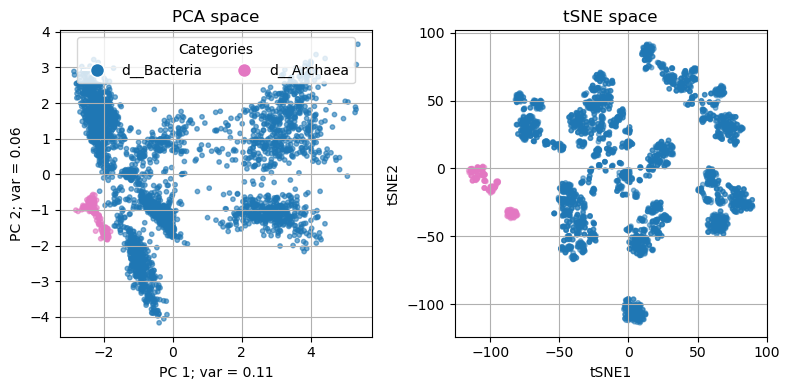

In [10]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:blue", "tab:pink"])
category_names = full_data['domain']
pca_run_and_plot(X, n_compon, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']],
                 category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']], colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by Phylum**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11369068 0.06242916 0.05329809 0.04972046 0.03812506 0.02856772
 0.02378797 0.02024784 0.01857993 0.01501786 0.01195041 0.01002442
 0.0085356  0.00788753 0.00746712 0.00698071 0.00635051 0.00614153
 0.00590525 0.00526031]
Total explained variance: 0.49996816656989884
Shape of the projected data = (3161, 2)


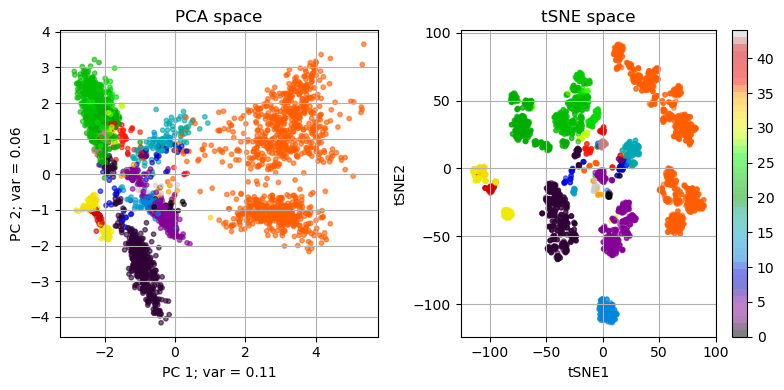

In [11]:
label_encoder = LabelEncoder()

plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = None
category_names = full_data['phylum']
pca_run_and_plot(X, n_compon, 
                 label_encoder.fit_transform(full_data['phylum']),
                 category_names, colors);
plt.legend().remove()
# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, 
          label_encoder.fit_transform(full_data['phylum']), 
          colors);


# Display the plots
plt.legend().remove()
plt.tight_layout()  
plt.show()

## 3. XGBoost training and feature selection

In [12]:
cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_train, y_train, X_test, y_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

XGBoost baseline test accuracy (all features) = {'accuracy': 0.9658385093167702, 'precision': np.float64(0.9763779527559056), 'recall': np.float64(0.9802371541501976), 'f1': np.float64(0.9783037475345168), 'roc_auc': np.float64(0.9845334249871112)}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9658385093167702, 'precision': np.float64(0.9763779527559056), 'recall': np.float64(0.9802371541501976), 'f1': np.float64(0.9783037475345168), 'roc_auc': np.float64(0.9845334249871112)}


### 3.1 Feature selection with Mutual Information

In [13]:
sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train.cpu(), y_train.cpu(), X_column_names)

In [14]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0109', 'COG1592', 'COG0026', 'COG1612', 'COG0508', 'COG0065', 'COG0276', 'COG0567', 'COG0843', 'COG1328']


Data after PCA reduction: (2517, 5)
Explained variance ratio: [0.5890371  0.09461268 0.07005155 0.05289732 0.05035774]
Total explained variance: 0.8569563861114887
Shape of the projected data = (2517, 2)


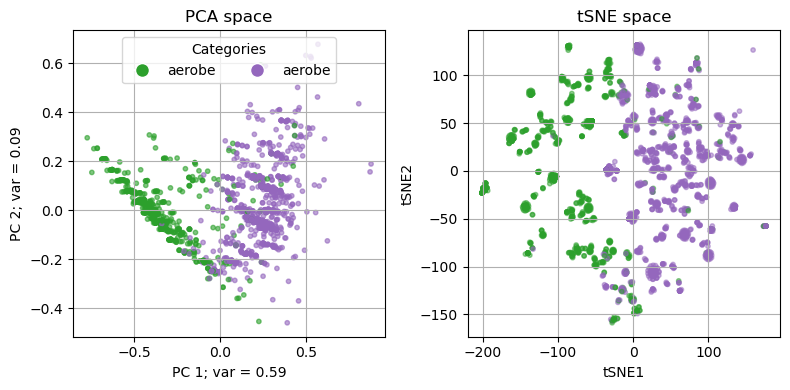

In [15]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()


In [16]:
y_label_train = y_train
y_label_test = y_test

X_val_train, X_val_test = X_train.cpu(), X_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [17]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.9257076588090506), 'precision': np.float64(0.9298294072992705), 'recall': np.float64(0.9556250000000001), 'f1': np.float64(0.9424076569894092), 'roc_auc': np.float64(0.917433086095272)}
{'accuracy': 0.9394409937888198, 'precision': np.float64(0.9481765834932822), 'recall': np.float64(0.9762845849802372), 'f1': np.float64(0.9620253164556962), 'roc_auc': np.float64(0.8919416280002292)}


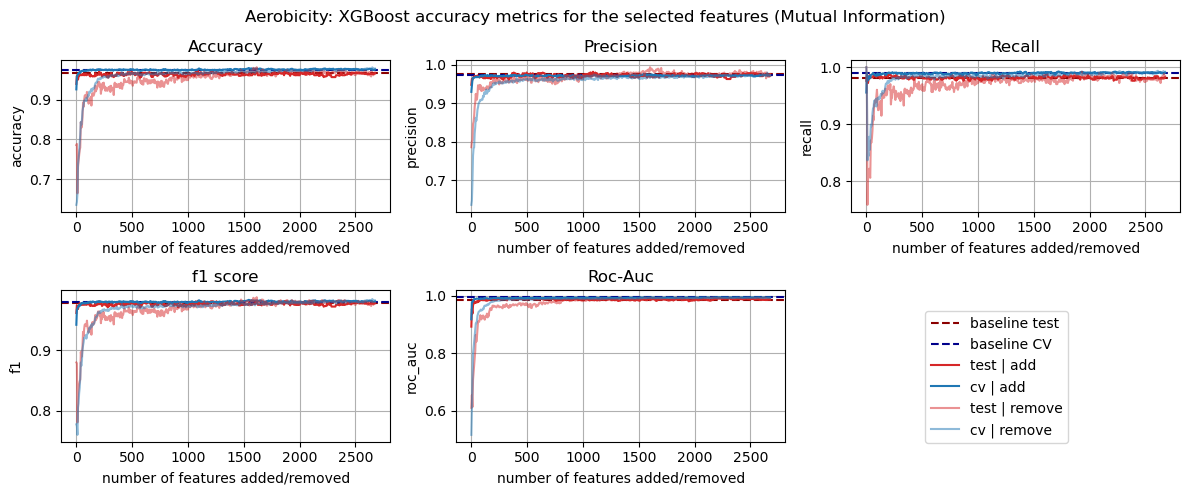

In [18]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Mutual Information)");

### 3.2 Feature selection with Random Forest

In [19]:
sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

Original feature count: 2677, Selected feature count: 288


In [20]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG0369', 'COG0026', 'COG1328', 'COG1592', 'COG0109', 'COG0567', 'COG0276', 'COG0320', 'COG0543', 'COG0508']


In [21]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (2517, 5)
Explained variance ratio: [0.57845446 0.09266789 0.0753604  0.05312839 0.04728701]
Total explained variance: 0.8468981513040585
Shape of the projected data = (2517, 2)


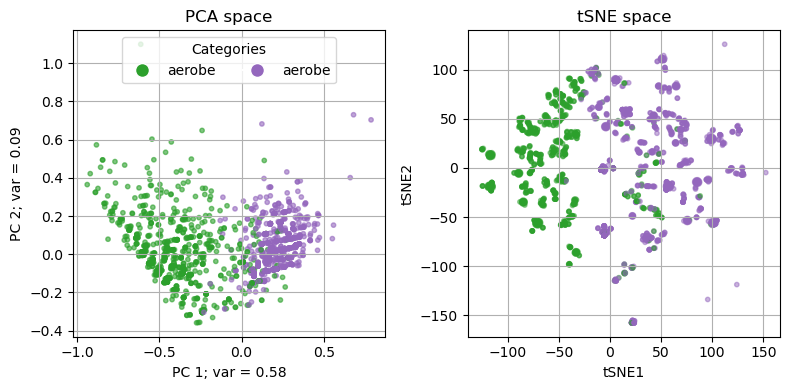

In [22]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [23]:
X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [24]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.8478454668812521), 'precision': np.float64(0.8622086102880624), 'recall': np.float64(0.90625), 'f1': np.float64(0.883451085728708), 'roc_auc': np.float64(0.8333895744238535)}
{'accuracy': 0.8664596273291926, 'precision': np.float64(0.9038461538461539), 'recall': np.float64(0.9288537549407114), 'f1': np.float64(0.9161793372319688), 'roc_auc': np.float64(0.7873918771839378)}


Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)')

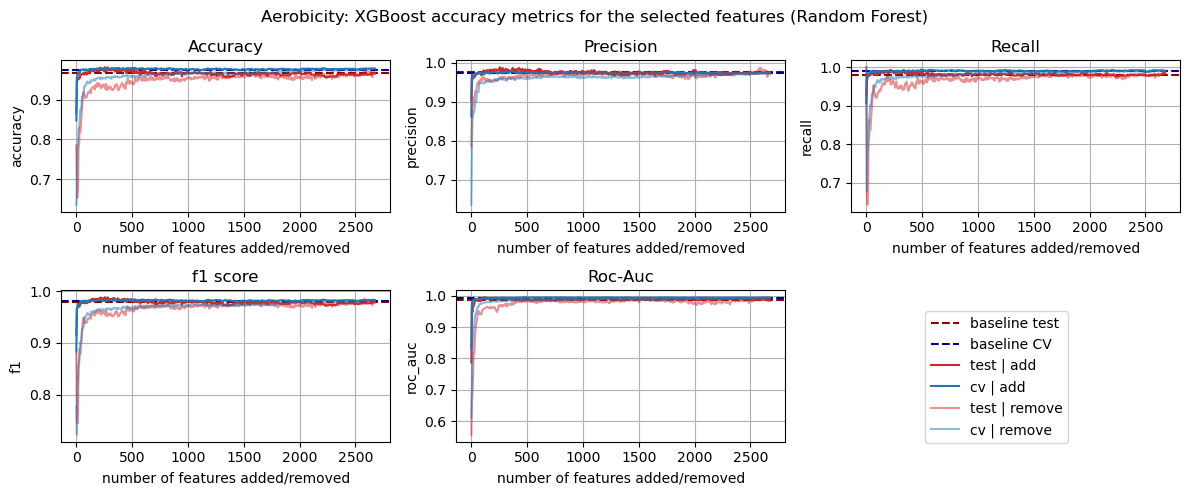

In [25]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)")

### 3.3 SHAP values

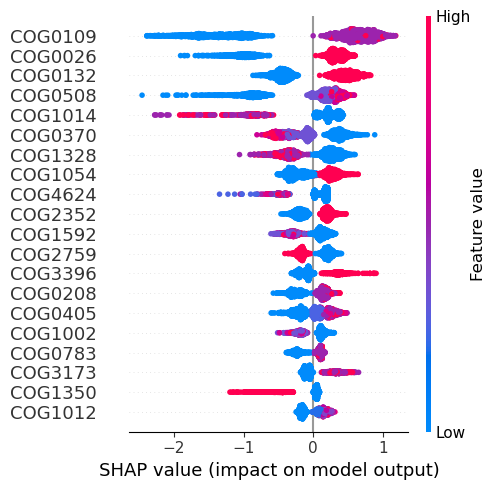

In [30]:
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, DEVICE) 

In [31]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG0109', 'COG0026', 'COG0132', 'COG0508', 'COG1014', 'COG0370', 'COG1328', 'COG1054', 'COG4624', 'COG2352']


Data after PCA reduction: (2517, 5)
Explained variance ratio: [0.42819049 0.19270436 0.10519487 0.07433185 0.05750431]
Total explained variance: 0.8579258807425492
Shape of the projected data = (2517, 2)


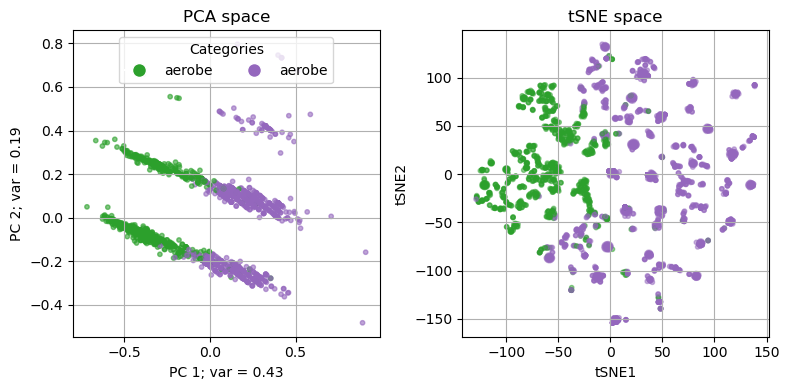

In [32]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']

pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [33]:
X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)')

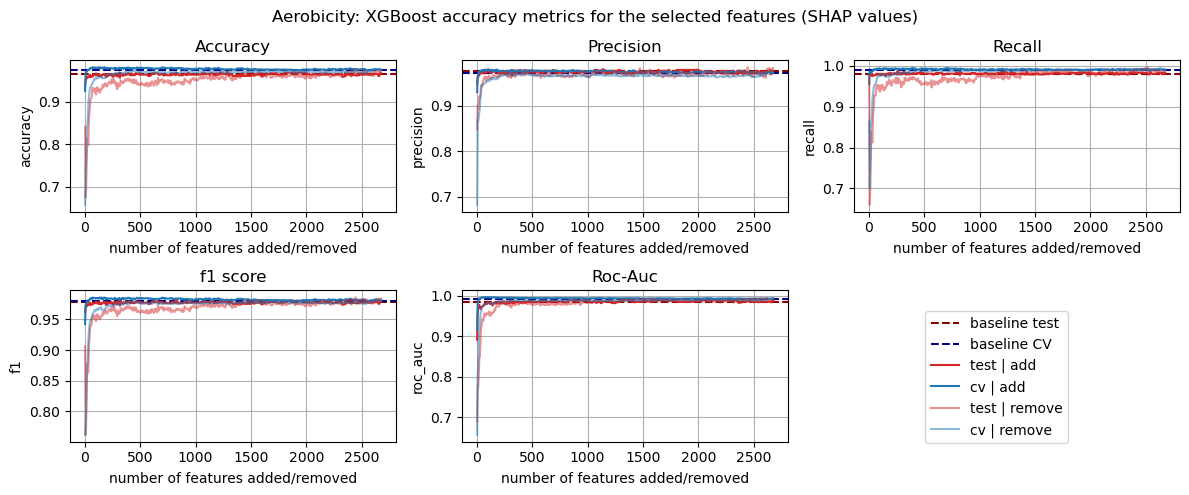

In [34]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat, n_cols)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)")

## 4. Feature comparison

In [88]:
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

df = pd.DataFrame(data)

df

,MI,RandomForest,SHAP
0,COG0109,COG0369,COG0109
1,COG1592,COG0026,COG0026
2,COG0026,COG1328,COG0132
3,COG1612,COG1592,COG0508
4,COG0508,COG0109,COG1014
5,COG0065,COG0567,COG0370
6,COG0276,COG0276,COG1328
7,COG0567,COG0320,COG1054
8,COG0843,COG0543,COG4624
9,COG1328,COG0508,COG2352


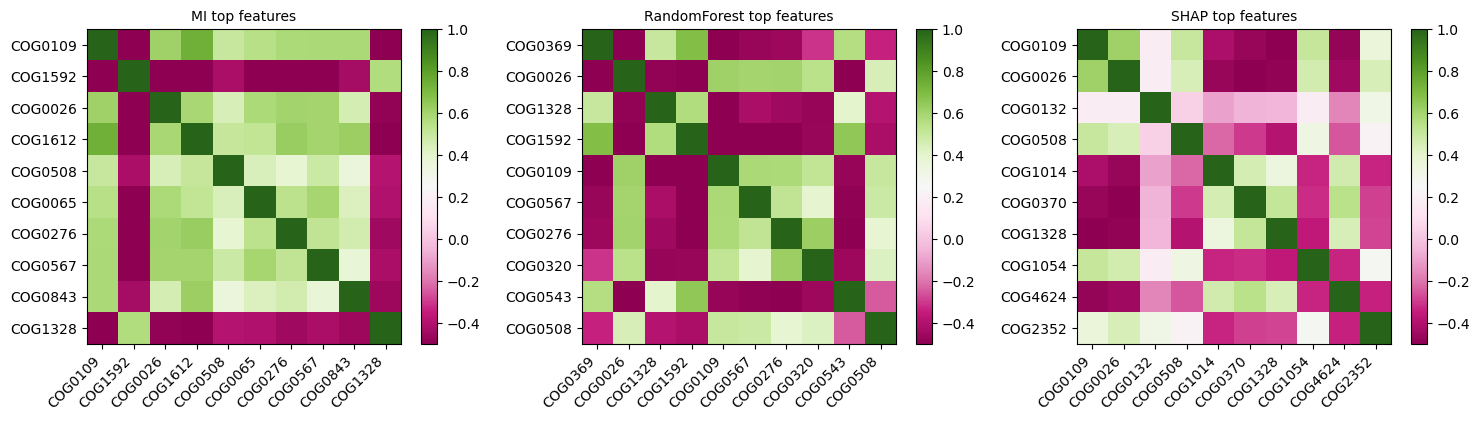

In [36]:
plt.figure(figsize=(15, 4))

vmin, vmax = -0.5, 1 #-0.6

# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RandomForest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_shap_counts) 
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()

# Display the plots
plt.tight_layout()  
plt.show()

In [100]:
make_cog_descr(df)

,MI,RandomForest,SHAP
0,COG0109: Polyprenyltransferase (heme O synthase),COG0369: Flavoprotein (flavin reductase) subun...,COG0109: Polyprenyltransferase (heme O synthase)
1,COG1592: Rubrerythrin,COG0026: Phosphoribosylaminoimidazole carboxyl...,COG0026: Phosphoribosylaminoimidazole carboxyl...
2,COG0026: Phosphoribosylaminoimidazole carboxyl...,COG1328: Anaerobic ribonucleoside-triphosphate...,COG0132: Dethiobiotin synthetase
3,COG1612: Heme A synthase,COG1592: Rubrerythrin,COG0508: Pyruvate/2-oxoglutarate dehydrogenase...
4,COG0508: Pyruvate/2-oxoglutarate dehydrogenase...,COG0109: Polyprenyltransferase (heme O synthase),COG1014: Pyruvate:ferredoxin oxidoreductase or...
5,COG0065: Homoaconitase/3-isopropylmalate dehyd...,"COG0567: 2-oxoglutarate dehydrogenase complex,...",COG0370: Fe2+ transporter FeoB
6,COG0276: Protoheme ferro-lyase (ferrochelatase),COG0276: Protoheme ferro-lyase (ferrochelatase),COG1328: Anaerobic ribonucleoside-triphosphate...
7,"COG0567: 2-oxoglutarate dehydrogenase complex,...",COG0320: Lipoate synthase,"COG1054: tRNA U34 5'-hydroxylase TrhO, rhodane..."
8,COG0843: Heme/copper-type cytochrome/quinol ox...,COG0543: NAD(P)H-flavin reductase,"COG4624: Iron only hydrogenase large subunit, ..."
9,COG1328: Anaerobic ribonucleoside-triphosphate...,COG0508: Pyruvate/2-oxoglutarate dehydrogenase...,COG2352: Phosphoenolpyruvate carboxylase
